In [1]:
import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download the Oxford IIIT Pet Dataset using the in-built pytorch datasets library

# train_split
raw_train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', download=True)

# test_split
raw_test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test', download=True)

print(len(raw_train_dataset))
print(len(raw_test_dataset))

100%|██████████| 791918971/791918971 [00:37<00:00, 21308033.32it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10628779.51it/s]


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet
3680
3669


In [3]:
# Helper dataset class to add transformations to the raw data

class preprocessDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        augmented_image = self.transform(image)
        return augmented_image, target

In [4]:
'''

# Different preprocessing steps are used for ResNet50 when using pytorch and tensorflow.

Ref: 1. https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
     2. https://github.com/keras-team/keras/blob/v2.14.0/keras/applications/resnet.py#L606-L613
     3. https://github.com/keras-team/keras/blob/v2.14.0/keras/applications/imagenet_utils.py#L178-L248


# R50_preprocess is equal to the below transformation.

R50_transform_pytorch = T.Compose([
                                    T.Resize(232, interpolation=T.InterpolationMode.BILINEAR),
                                    T.CenterCrop(224),
                                    T.ToTensor(),
                                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                  ])

'''

# Pretrained weights that going to load to the model
weights = torchvision.models.resnet.ResNet34_Weights.DEFAULT
# weights = torchvision.models.resnet.ResNet50_Weights.IMAGENET1K_V2

# Requiered preprocessing for the R50 model from torchvision
R50_preprocess = weights.transforms()

In [5]:
# Preprocessed datasets

train_dataset = preprocessDataset(raw_train_dataset, R50_preprocess)
test_dataset = preprocessDataset(raw_test_dataset, R50_preprocess)

In [6]:
# Visualize the preprocessed data with raw data

raw_sample = []
train_sample = []

rw = iter(raw_train_dataset)
tr = iter(train_dataset)

for i in range(16):
    raw_sample.append(next(rw)[0])
    train_sample.append(next(tr)[0])

grid1 = torchvision.utils.make_grid([T.Resize((224,224),antialias=True)(T.ToTensor()(i)) for i in raw_sample], nrow=8)
grid2 = torchvision.utils.make_grid([i for i in train_sample], nrow=8)

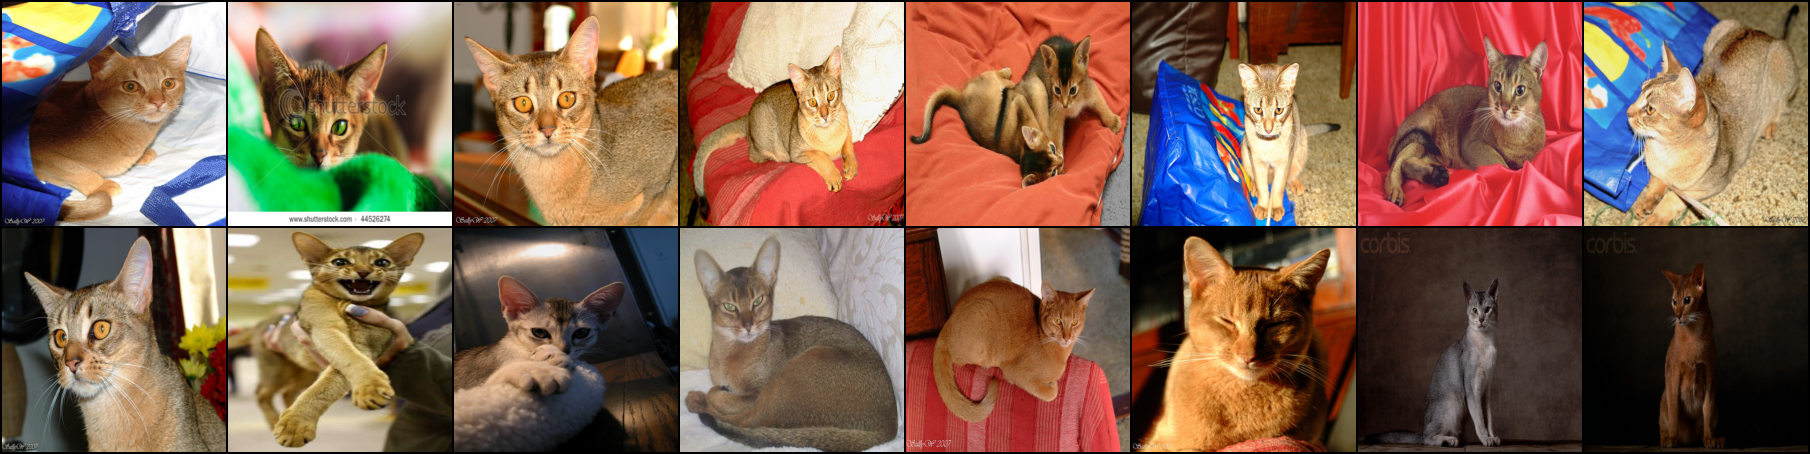

In [7]:
# raw sample preview

T.ToPILImage()(grid1)

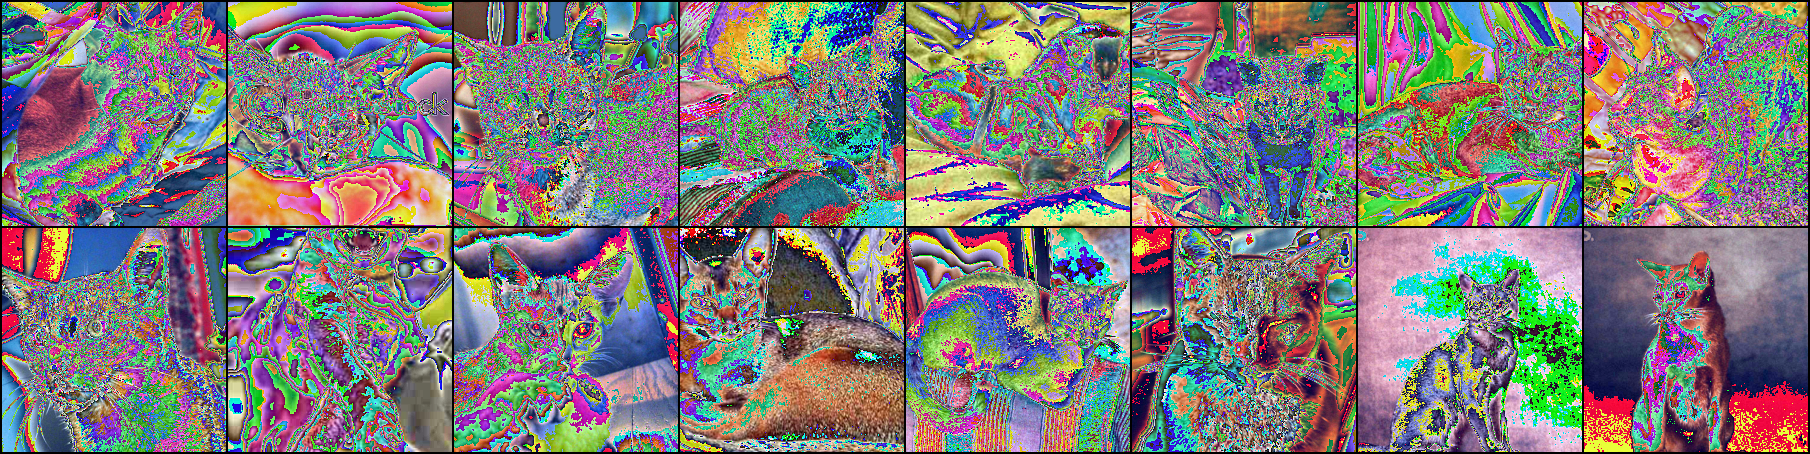

In [8]:
# train sample preview after preprocessing

T.ToPILImage()(grid2)

In [9]:
# split the train_dataset in to train and validation datasets, ratio = 80% : 20%

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=0)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2944
736
3669


In [10]:
# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:",len(val_loader))
print("Test batches:",len(test_loader))

Train batches: 46
Val batches: 12
Test batches: 58


In [12]:
# Model class

class ResNet_Classifier(torch.nn.Module):
    def __init__(self, weights, freeze_weights, dropout):
        super(ResNet_Classifier, self).__init__()

        # Load the ResNet model
        resnet = torchvision.models.resnet34(weights=weights)
#         resnet = torchvision.models.resnet50(weights=weights)
        
        out_features = 512 # for ResNet34
#         out_features = 2048 # for ResNet50
        
        #Freezing the weights
        if freeze_weights:
            for param in resnet.parameters():
                param.requires_grad = False

        # Remove the final layer
        base_model = nn.Sequential(*list(resnet.children())[:-1])

        self.layers = nn.Sequential( 
                                        base_model,
                                        nn.Flatten(),
                                        nn.Linear(out_features, 512),
                                        nn.ReLU(),
                                        nn.Dropout(dropout),
                                        nn.Linear(512, 37)
                                    )

    def forward(self, x):
        outputs = self.layers(x)
        
        return outputs

In [13]:
print(ResNet_Classifier(weights,True,0.1))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s] 


ResNet_Classifier(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps

In [14]:
# Helper functions

def save_model(model,epoch, name=''):
    now = datetime.datetime.now()
    now = now + datetime.timedelta(hours=5, minutes=30)
    date_time = now.strftime("%Y-%m-%d_%H-%M-%S")

    torch.save(model.state_dict(), f'model_{name}_epoch[{epoch}]_{date_time}.pt')
    
def view_confusion_matrix(model, test_loader, figsize=(15,15)):
    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    test_labels = []
    preds = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_labels.append(labels.cpu().numpy())
            preds.append(predicted.cpu().numpy())
    
    test_labels = np.concatenate(test_labels,axis=0)
    preds = np.concatenate(preds,axis=0)
    
    cm = confusion_matrix(test_labels, preds, labels=[i for i in range(37)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[i for i in range(37)])

    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax)
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return average_loss, accuracy


def early_stop(val_loss, val_history, patience):
    if val_loss < val_history['best']:
        val_history['best'] = val_loss
        val_history['no_improvement'] = 0
    else:
        val_history['no_improvement'] += 1

    if val_history['no_improvement'] >= patience:
        return True

    return False

def train_model(model, dataloader, num_epochs, train_transform, device,early_stop_patience, history, val_history, data_augment=False):

    current_lr = optimizer.param_groups[0]['lr']
    best_val = 0

    # Traning loop
    for epoch in range(num_epochs):
        
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in dataloader:
            # load the batch to GPU
            images, labels = images.to(device), labels.to(device)

            # Random image augmentation
            if data_augment:
                images = train_transform(images)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Backward pass
            loss = criterion(outputs, labels)
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = correct_predictions / total_samples
        total_loss = total_loss/len(dataloader)
        
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        
        # save the best model so far
        if best_val < val_accuracy and val_accuracy > 0.92:
            best_val = val_accuracy
            save_model(model,epoch+1, str(int(10000* val_accuracy)))

        if (epoch+1)%5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr}, ', end='')
            print(f'train_loss: {total_loss:.5f}, train_acc: {accuracy:.5f}, ', end='')
            print(f'val_loss: {val_loss:.5f}, val_acc: {val_accuracy:.5f}')
                    
        if early_stop(val_loss, val_history, early_stop_patience):
            print(f"Stopped due to no improvement for {val_history['no_improvement']} epochs")
            save_model(model,epoch+1)
            break
                
        model.train(True) # Switch back to training mode
        
        # Update the learning rate
        scheduler.step(val_loss) 
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(total_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(accuracy)
        history['val_acc'].append(val_accuracy)

        if (epoch+1) % 50 == 0:
            save_model(model, epoch+1)

In [15]:
# Training

num_epochs = 500            # number of epochs to train
learning_rate = 0.001       # initial Learning rate
dropout = 0.2
# weight_decay = 0.001         # L2 panelty coefficient for AdamW
data_augment= False
early_stop_patience = 20   # number of epochs
lr_factor = 0.1
lr_scheduler_patience = 4  # number of epochs

# Data Augmentations
train_transform = T.RandomChoice([
                                    T.RandomRotation(20),
                                    T.ColorJitter(brightness=[0.8,1.4], hue=0.1,saturation = 0.1),
                                    T.RandomHorizontalFlip(0.4),
                                    T.RandomPerspective(distortion_scale=0.4)
                                 ], 
                                    [0.3, 0.3, 0.3, 0.1] )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet_Classifier(weights=weights, freeze_weights=True, dropout=dropout)
model = model.to(device)
model = torch.nn.DataParallel(model)

# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_factor, patience=lr_scheduler_patience)

history = {'train_loss':[],'val_loss':[], 'train_acc':[], 'val_acc':[]}
val_history = {'best': 1e9, 'no_improvement':0}

train_model(model, train_loader, num_epochs, train_transform, device,early_stop_patience, history, val_history,data_augment)

Epoch [5/500], LR: 0.001, train_loss: 3.44126, train_acc: 0.12058, val_loss: 3.42040, val_acc: 0.17799
Epoch [10/500], LR: 0.001, train_loss: 3.22982, train_acc: 0.31624, val_loss: 3.20695, val_acc: 0.41440
Epoch [15/500], LR: 0.001, train_loss: 2.99958, train_acc: 0.48573, val_loss: 2.97782, val_acc: 0.59511
Epoch [20/500], LR: 0.001, train_loss: 2.74818, train_acc: 0.61719, val_loss: 2.72945, val_acc: 0.67935
Epoch [25/500], LR: 0.001, train_loss: 2.48836, train_acc: 0.69395, val_loss: 2.46754, val_acc: 0.73913
Epoch [30/500], LR: 0.001, train_loss: 2.23533, train_acc: 0.72996, val_loss: 2.20330, val_acc: 0.78125
Epoch [35/500], LR: 0.001, train_loss: 1.98741, train_acc: 0.78091, val_loss: 1.95085, val_acc: 0.81114
Epoch [40/500], LR: 0.001, train_loss: 1.75099, train_acc: 0.80435, val_loss: 1.72099, val_acc: 0.83832
Epoch [45/500], LR: 0.001, train_loss: 1.56490, train_acc: 0.81284, val_loss: 1.52062, val_acc: 0.85054
Epoch [50/500], LR: 0.001, train_loss: 1.39338, train_acc: 0.8366

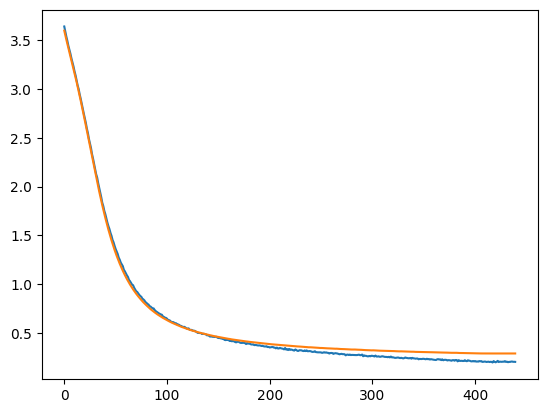

In [16]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.show()

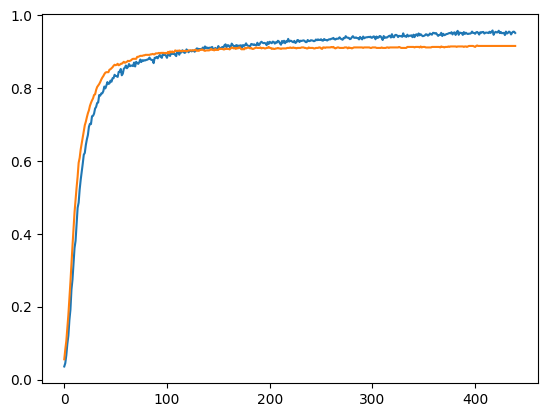

In [17]:
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.show()

In [18]:
# Evaluate on test_dataset
loss, acc = evaluate_model(model, test_loader)
print(f'test_loss: {loss}, test_acc: {acc*100:.3f}%')

test_loss: 0.3299936439585069, test_acc: 90.025%


100%|██████████| 58/58 [00:24<00:00,  2.34it/s]


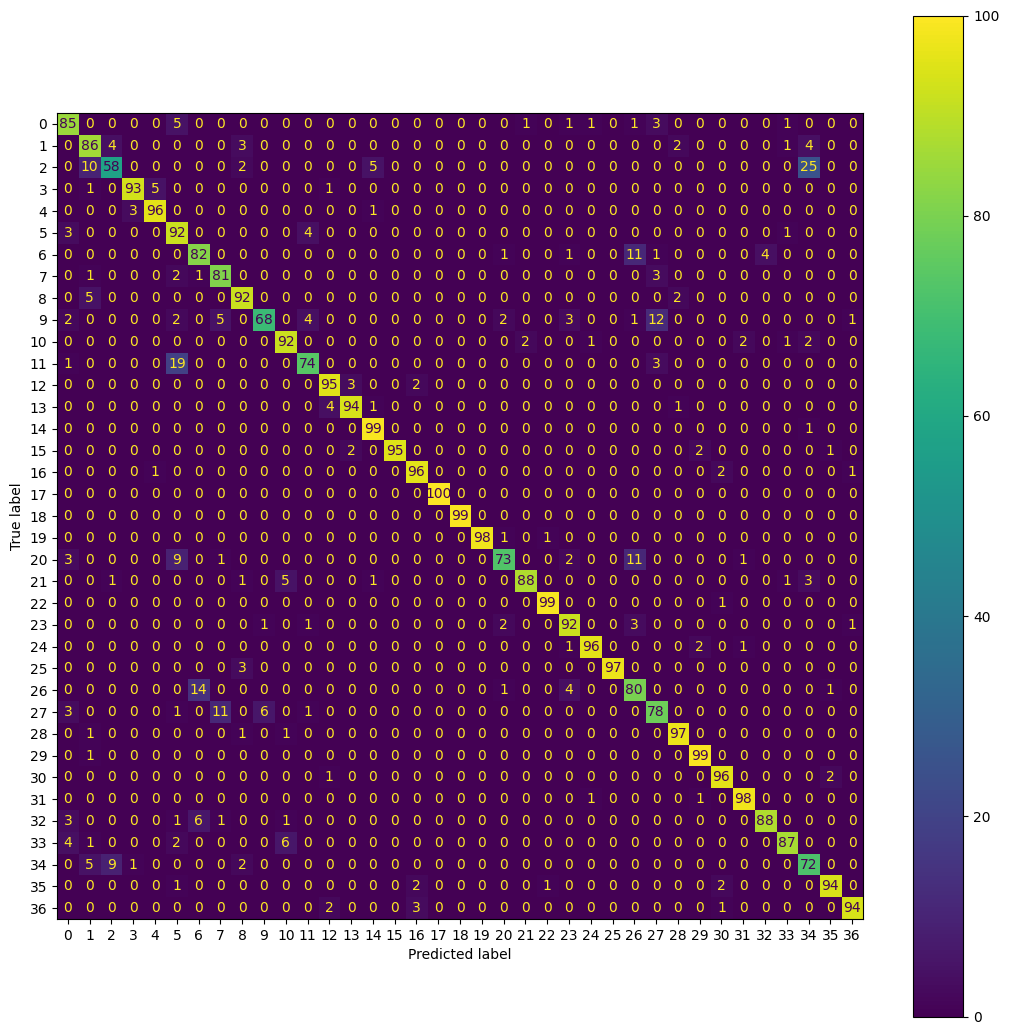

In [19]:
view_confusion_matrix(model, test_loader, figsize=(13,13))

In [20]:
# # Load and Evaluate saved models

# load_path = 'model_9211_epoch[53]_2023-12-10_18-44-11.pt'

# model = ResNet_Classifier(weights=weights, freeze_weights=False, dropout=dropout)
# model = model.to(device)
# model = torch.nn.DataParallel(model)

# model.load_state_dict(torch.load(load_path))
# model.eval()  # Switch to the evaluation mode

# loss, acc = evaluate_model(model, test_loader)
# print(f'test_loss: {loss}, test_acc: {acc*100:.3f}%')